In [1]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [2]:
def create_clarity_cat(clarity):
    if clarity == 'FL':
        c_cat = 1
    elif clarity == 'IF':
        c_cat = 2
    elif clarity == 'VVS1' or clarity == 'VVS2':
        c_cat = 3
    elif clarity == 'VS1' or clarity == 'VS2':
        c_cat = 4
    elif clarity == 'SI1' or clarity == 'SI2':
        c_cat = 5
    elif clarity == 'I1' or clarity == 'I2' or clarity == 'I3':
        c_cat = 6
    else:
        c_cat = 0
    return c_cat

def create_color_cat(color):
    if color == 'D':
        color_cat = 1
    elif color == 'E':
        color_cat = 2
    elif color == 'F':
        color_cat = 3
    elif color == "G" or color == "H":
        color_cat = 4
    elif color =="I":
        color_cat = 5
    else:
        color_cat = 0
    return color_cat

    
def create_cut_cat(cut):
    if cut == 'Poor':
        cut_cat = 1
    elif cut == 'Fair':
        cut_cat = 2
    elif cut == 'Good':
        cut_cat = 3
    elif cut == 'Very Good':
        cut_cat = 4
    elif cut == 'Ideal':
        cut_cat = 5
    elif cut == 'Signature-Ideal':
        cut_cat = 6
    else: 
        cut_cat = 0
    return cut_cat

def create_PS_cat(polish):
    if polish == 'G':
        polish_cat = 1
    elif polish == 'VG':
        polish_cat = 2
    elif polish == 'EX':
        polish_cat = 3
    elif polish == 'ID':
        polish_cat = 4
    else:
        polish_cat = 0
    return polish_cat


def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in x_valid.columns:
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

def linear_regression(fts, target):
    """
    Линейная регрессия.

    Parameters
    ----------
    fts: набор полей для обучения модели 
    target: str
        Название целевого поля.
    
    Returns
    -------
    
    """
    train_scaled = train.loc[:,fts]
    valid_scaled = valid.loc[:,fts]
    
    
    lr = LinearRegression()
    lr.fit(train_scaled, train[target])
    pred = lr.predict(train_scaled)
    print("метрика R2 для тренировочного набора train:", r2(train[target], pred))
    pred_valid = lr.predict(valid_scaled.loc[:,fts])
    print("метрика R2 для валидационного набора valid:", r2(valid[target], pred_valid))
    mse = MSE(valid[target],pred_valid)
    print("метрика MSE:", mse)    
    return lr

def knn(fts, target):
    """
    Линейная регрессия.

    Parameters
    ----------
    fts: набор полей для обучения модели 
    target: str
        Название целевого поля.
    
    Returns
    -------
    
    """
    train_scaled = train.loc[:,fts]
    valid_scaled = valid.loc[:,fts]
    knn = KNN(n_neighbors=2,weights='distance')
    knn.fit(train_scaled, train[target])
    pred = knn.predict(train_scaled)
    pred_valid = knn.predict(valid_scaled)
    print("метрика R2 для тренировочного набора train:", r2(train[target], pred))
    print("метрика R2 для валидационного набора valid:", r2(valid[target], pred_valid))
    mse = MSE(valid[target],pred_valid)
    print("метрика MSE:", mse)    
    return knn

In [3]:
def create_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy() 
    X['Color'] = X['Color'].fillna(X['Color'].mode())
    X['Symmetry'] = X['Symmetry'].fillna(X['Symmetry'].mode())
#Добавление новой категориальной переменной - возрастная категория
    X["Cut_cat"] = X["Cut"].apply(lambda x: create_cut_cat(x))
    X["Color_cat"] = X["Color"].apply(lambda x: create_color_cat(x))
    X["Clarity_cat"] = X["Clarity"].apply(lambda x: create_clarity_cat(x))
    X["Polish_cat"] = X["Polish"].apply(lambda x: create_PS_cat(x))
    X["Symmetry_cat"] = X["Symmetry"].apply(lambda x: create_PS_cat(x))
        
    freq_encoder = X["Clarity"].value_counts(normalize=True)
    X["clarity_freq_enc"] = X["Clarity"].map(freq_encoder)
    
#    X["Возраст"] = X["Возраст"] / scaler = StandardScaler()
    X = X[["ID","Carat Weight", "Cut_cat", "Color_cat", "Clarity_cat", "Polish_cat", "Symmetry_cat", "clarity_freq_enc", "Price"]]
    X = X[(X["Cut_cat"] > 0) & (X["Color_cat"] > 0) & (X["Clarity_cat"] > 0)]
    return X

In [4]:
df = pd.read_excel("Data\Sarah gets a diamond data.xls")

In [5]:
df.columns = list(df.iloc[1,:])

In [6]:
df = df.iloc[2:,:]

In [7]:
df

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
2,1,1.1,Ideal,H,SI1,VG,EX,GIA,5169
3,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
4,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183
5,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370
6,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...,...
5997,5996,1.03,Ideal,D,SI1,EX,EX,GIA,NaN
5998,5997,1,Very Good,D,SI1,VG,VG,GIA,NaN
5999,5998,1.02,Ideal,D,SI1,EX,EX,GIA,NaN
6000,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,NaN


In [8]:
df.describe()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
count,6000,6000.00,6000,5999,6000,6000,5999,6000,4500.0
unique,6000,198.00,8,7,8,5,5,2,3791.0
top,6000,1.01,Ideal,G,SI1,EX,VG,GIA,5534.0
freq,1,448.00,2479,1501,2059,2425,2416,5266,5.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 2 to 6001
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            6000 non-null   object
 1   Carat Weight  6000 non-null   object
 2   Cut           6000 non-null   object
 3   Color         5999 non-null   object
 4   Clarity       6000 non-null   object
 5   Polish        6000 non-null   object
 6   Symmetry      5999 non-null   object
 7   Report        6000 non-null   object
 8   Price         4500 non-null   object
dtypes: object(9)
memory usage: 422.0+ KB


In [10]:
df['Color'].unique()

array(['H', 'E', 'G', 'D', 'F', 'I', nan, '-'], dtype=object)

In [11]:
df['Symmetry'].unique()

array(['EX', 'ID', 'VG', 'G', '  ', nan], dtype=object)

In [12]:
df['Polish'].unique()

array(['VG', 'ID', 'EX', 'G', 'НД'], dtype=object)

In [13]:
df_new = create_features(df)

In [14]:
df_new

,ID,Carat Weight,Cut_cat,Color_cat,Clarity_cat,Polish_cat,Symmetry_cat,clarity_freq_enc,Price
2,1,1.1,5,4,5,2,3,0.343167,5169
3,2,0.83,5,4,4,4,4,0.198667,3470
4,3,0.85,5,4,5,3,3,0.343167,3183
5,4,0.91,5,2,5,2,2,0.343167,4370
6,5,0.83,5,4,5,3,3,0.343167,3171
...,...,...,...,...,...,...,...,...,...
5997,5996,1.03,5,1,5,3,3,0.343167,NaN
5998,5997,1,4,1,5,2,2,0.343167,NaN
5999,5998,1.02,5,1,5,3,3,0.343167,NaN
6000,5999,1.27,6,4,4,3,3,0.198667,NaN


Исследование данных

Исследование распределения по чистоте в данном наборе бриллиантов  

In [15]:
print('1 - FL')
print('2 - IF')
print('3 - VVS1/VVS2')
print('4 - VS1/VS2')
print('5 - SI1/SI2')

1 - FL
2 - IF
3 - VVS1/VVS2
4 - VS1/VS2
5 - SI1/SI2


In [16]:
df_new['Clarity_cat'].value_counts(normalize=True)

4    0.461038
5    0.343234
3    0.158685
2    0.036376
1    0.000667
Name: Clarity_cat, dtype: float64

In [17]:
df_Clarity = df_new.groupby('Clarity_cat')['ID'].count().reset_index().sort_values('Clarity_cat') 
df_Clarity

,Clarity_cat,ID
0,1,4
1,2,218
2,3,951
3,4,2763
4,5,2057


Text(0, 0.5, 'количество бриллиантов')

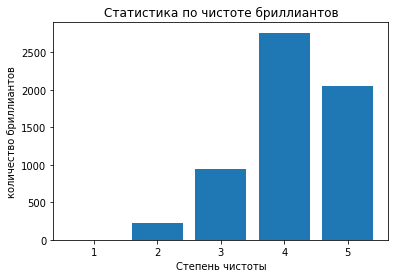

In [18]:
plt.bar(df_Clarity['Clarity_cat'], df_Clarity['ID'])
plt.title('Статистика по чистоте бриллиантов')
plt.xlabel('Степень чистоты')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [19]:
serie = df_new.groupby('Clarity_cat')['ID'].count()
serie

Clarity_cat
1       4
2     218
3     951
4    2763
5    2057
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по чистоте бриллиантов')

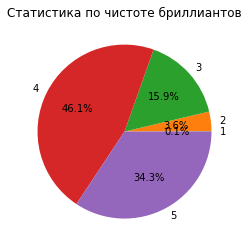

In [20]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по чистоте бриллиантов')

Исследование распределения по цвету в данном наборе бриллиантов

In [21]:
print('1 - D (совершенно бесцветные)')
print('2 - E')
print('3 - F')
print('4 - G-H')
print('5 - I-J')

1 - D (совершенно бесцветные)
2 - E
3 - F
4 - G-H
5 - I-J


In [22]:
df_new['Color_cat'].value_counts(normalize=True)

4    0.430002
3    0.168697
5    0.161355
2    0.129818
1    0.110128
Name: Color_cat, dtype: float64

In [23]:
df_Color = df_new.groupby('Color_cat')['ID'].count().reset_index().sort_values('Color_cat') 
df_Color

,Color_cat,ID
0,1,660
1,2,778
2,3,1011
3,4,2577
4,5,967


Text(0, 0.5, 'количество бриллиантов')

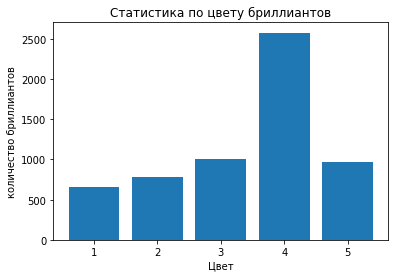

In [24]:
plt.bar(df_Color['Color_cat'], df_Color['ID'])
plt.title('Статистика по цвету бриллиантов')
plt.xlabel('Цвет')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [25]:
serie = df_new.groupby('Color_cat')['ID'].count()
serie

Color_cat
1     660
2     778
3    1011
4    2577
5     967
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по цвету бриллиантов')

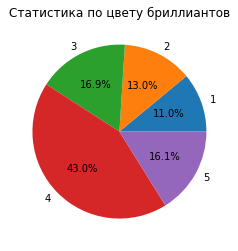

In [26]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по цвету бриллиантов')

Исследование распределения по огранке в данном наборе бриллиантов

In [27]:
print('1 - Poor')
print('2 - Fair')
print('3 - Good')
print('4 - Very Good')
print('5 - Ideal')
print('6 - Signature-Ideal')

1 - Poor
2 - Fair
3 - Good
4 - Very Good
5 - Ideal
6 - Signature-Ideal


In [28]:
df_new['Cut_cat'].value_counts(normalize=True)

5    0.413482
4    0.404806
3    0.117971
6    0.042216
2    0.021525
Name: Cut_cat, dtype: float64

In [29]:
df_Cut = df_new.groupby('Cut_cat')['ID'].count().reset_index().sort_values('Cut_cat') 
df_Cut

,Cut_cat,ID
0,2,129
1,3,707
2,4,2426
3,5,2478
4,6,253


Text(0, 0.5, 'количество бриллиантов')

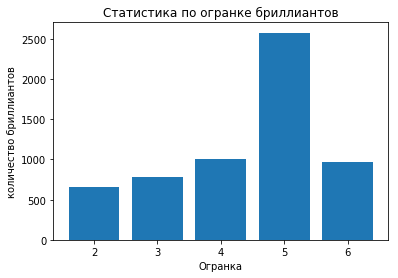

In [30]:
plt.bar(df_Cut['Cut_cat'], df_Color['ID'])
plt.title('Статистика по огранке бриллиантов')
plt.xlabel('Огранка')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [31]:
serie = df_new.groupby('Cut_cat')['ID'].count()
serie

Cut_cat
2     129
3     707
4    2426
5    2478
6     253
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по огранке бриллиантов')

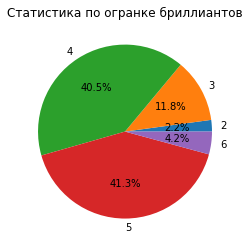

In [32]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по огранке бриллиантов')

Исследование распределения по симметрии огранки в данном наборе бриллиантов

In [33]:
print('1 - G (good)')
print('2 - VG (very good)')
print('3 - EX (excellent)')
print('4 - ID (ideal)')

1 - G (good)
2 - VG (very good)
3 - EX (excellent)
4 - ID (ideal)


In [34]:
df_new['Symmetry_cat'].value_counts(normalize=True)

2    0.402470
3    0.343234
1    0.152511
4    0.101452
0    0.000334
Name: Symmetry_cat, dtype: float64

In [35]:
df_Symmetry = df_new.groupby('Symmetry_cat')['ID'].count().reset_index().sort_values('Symmetry_cat') 
df_Symmetry

,Symmetry_cat,ID
0,0,2
1,1,914
2,2,2412
3,3,2057
4,4,608


Text(0, 0.5, 'количество бриллиантов')

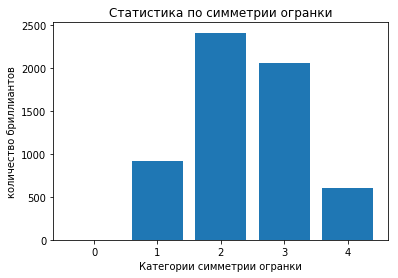

In [36]:
plt.bar(df_Symmetry['Symmetry_cat'], df_Symmetry['ID'])
plt.title('Статистика по симметрии огранки')
plt.xlabel('Категории симметрии огранки')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [37]:
serie = df_new.groupby('Symmetry_cat')['ID'].count()
serie

Symmetry_cat
0       2
1     914
2    2412
3    2057
4     608
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по цвету симметрии огранки')

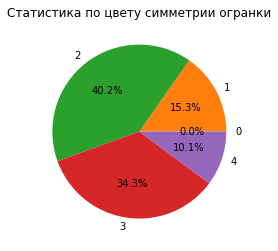

In [38]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по цвету симметрии огранки')

Исследование распределения по полировке в данном наборе бриллиантов

In [39]:
print('1 - G (good)')
print('2 - VG (very good)')
print('3 - EX (excellent)')
print('4 - ID (ideal)')

1 - G (good)
2 - VG (very good)
3 - EX (excellent)
4 - ID (ideal)


In [40]:
df_new['Polish_cat'].value_counts(normalize=True)

3    0.404138
2    0.401468
4    0.099282
1    0.094944
0    0.000167
Name: Polish_cat, dtype: float64

In [41]:
df_Polish = df_new.groupby('Polish_cat')['ID'].count().reset_index().sort_values('Polish_cat') 
df_Polish

,Polish_cat,ID
0,0,1
1,1,569
2,2,2406
3,3,2422
4,4,595


Text(0, 0.5, 'количество бриллиантов')

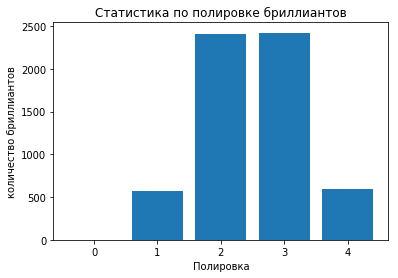

In [42]:
plt.bar(df_Polish['Polish_cat'], df_Polish['ID'])
plt.title('Статистика по полировке бриллиантов')
plt.xlabel('Полировка')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [43]:
serie = df_new.groupby('Polish_cat')['ID'].count()
serie

Polish_cat
0       1
1     569
2    2406
3    2422
4     595
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по полировке бриллиантов')

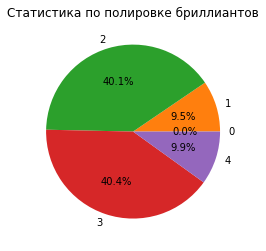

In [44]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по полировке бриллиантов')

Исследование зависимости стоимости бриллианта от чистоты 

In [45]:
train = df_new[~df_new['Price'].isnull()]

In [46]:
train['int_price'] = train['Price'].apply(lambda x: int(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
print('1 - FL')
print('2 - IF')
print('3 - VVS1/VVS2')
print('4 - VS1/VS2')
print('5 - SI1/SI2')

1 - FL
2 - IF
3 - VVS1/VVS2
4 - VS1/VS2
5 - SI1/SI2


In [65]:
df_Clarity = train.groupby('Clarity_cat')['int_price'].median().reset_index().sort_values('Clarity_cat') 
df_Clarity

,Clarity_cat,int_price
0,1,81399.0
1,2,11930.0
2,3,10470.0
3,4,8339.0
4,5,5409.5


Text(0, 0.5, 'стоимость бриллиантов')

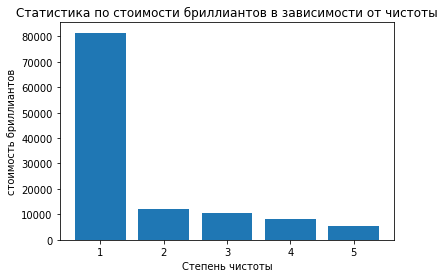

In [66]:
plt.bar(df_Clarity['Clarity_cat'], df_Clarity['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от чистоты')
plt.xlabel('Степень чистоты')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: наблюдается очень четкая зависимость цены от чистоты бриллианта.

Исследование зависимости стоимости бриллианта от цвета 

In [50]:
print('1 - D (совершенно бесцветные)')
print('2 - E')
print('3 - F')
print('4 - G-H')
print('5 - I-J')

1 - D (совершенно бесцветные)
2 - E
3 - F
4 - G-H
5 - I-J


In [67]:
df_Color = train.groupby('Color_cat')['int_price'].median().reset_index() 
df_Color

,Color_cat,int_price
0,1,7653.0
1,2,7178.0
2,3,8628.0
3,4,8093.0
4,5,6689.5


Text(0, 0.5, 'стоимость бриллиантов')

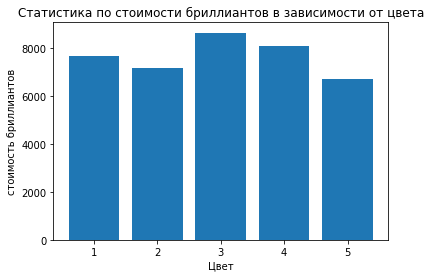

In [68]:
plt.bar(df_Color['Color_cat'], df_Color['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от цвета')
plt.xlabel('Цвет')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: зависимость цены от цвета бриллианта не очень четкая.

Исследование зависимости стоимости бриллианта от огранки 

In [53]:
print('1 - Poor')
print('2 - Fair')
print('3 - Good')
print('4 - Very Good')
print('5 - Ideal')
print('6 - Signature-Ideal')

1 - Poor
2 - Fair
3 - Good
4 - Very Good
5 - Ideal
6 - Signature-Ideal


In [70]:
df_Cut = train.groupby('Cut_cat')['int_price'].median().reset_index() 
df_Cut

,Cut_cat,int_price
0,2,4771.0
1,3,6063.5
2,4,7079.0
3,5,9221.5
4,6,9434.0


Text(0, 0.5, 'стоимость бриллиантов')

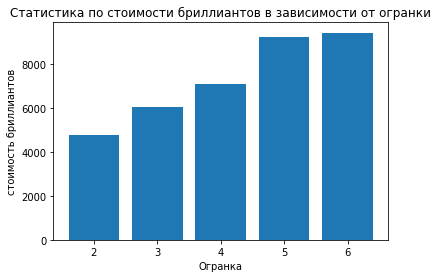

In [71]:
plt.bar(df_Cut['Cut_cat'], df_Cut['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от огранки')
plt.xlabel('Огранка')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: зависимость цены от цвета бриллианта четкая.

Исследование распределений весов камней в тренировочном и тестовом наборах 

In [87]:
def my_basic_research(df, column = "volume"):
    print("среднее: ", df[column].mean())
    print("средне-квадратичное отклонение: ", df[column].std())
    print("медиана: ", df[column].median())    
    print("50 перцентиль: ", np.percentile(df[column], 50))
    print("75 перцентиль: ", np.percentile(df[column], 75))
    print("99 перцентиль: ", np.percentile(df[column], 99))
    print("мода: ", df[column].mode())
    print("Самое популярное значение метрики, топ 1")
    print(df[column].value_counts().nlargest(1))
    print("------------------------------------")
    

In [88]:
my_basic_research(train,'Carat Weight')

среднее:  4.778405249110243
средне-квадратичное отклонение:  170.19018389053866
медиана:  1.13
50 перцентиль:  1.13
75 перцентиль:  1.58
99 перцентиль:  2.52
мода:  0    1.01
dtype: object
Самое популярное значение метрики, топ 1
1.01    345
Name: Carat Weight, dtype: int64
------------------------------------


Медиана и среднее сильно различаются, значит много выбросов.

In [96]:
my_basic_research(df_new[df_new['Price'].isnull()],'Carat Weight')

среднее:  1.344068136272542
средне-квадратичное отклонение:  0.4776058027714655
медиана:  1.14
50 перцентиль:  1.14
75 перцентиль:  1.62
99 перцентиль:  2.5103999999999997
мода:  0    1.01
dtype: object
Самое популярное значение метрики, топ 1
1.01    101
Name: Carat Weight, dtype: int64
------------------------------------


В тренировочном и тестовом наборе медианы веса камней почти совпадают. В тестовом наборе меньше выбросов ('экстремально больших весов).

Исследование зависимости стоимости бриллианта от веса в тренировочном наборе

In [90]:
train_99procentile = np.percentile(train['Carat Weight'], 99)
train_99procentile

2.52

In [93]:
#train['int_Carat Weight'] = train['Carat Weight'] * 100
#train['int_Carat Weight'] = train['int_Carat Weight'].apply(lambda x: int(x))
serie = train[train['Carat Weight'] < train_99procentile].sort_values('Carat Weight').set_index('Carat Weight')['Price'] 
serie

Carat Weight
0.75     2501
0.75     3535
0.75     5239
0.75     3949
0.75     2923
        ...  
2.51    31298
2.51    24351
2.51    28105
2.51    21656
2.51    44441
Name: Price, Length: 4450, dtype: object

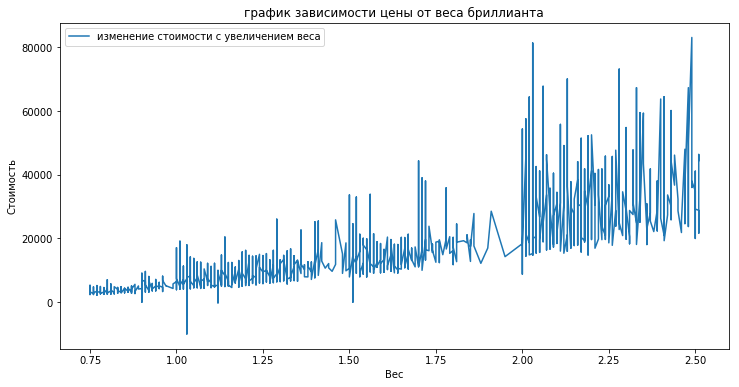

In [94]:
#на графике лучше вывести и модельные и реальные показатели одновременно
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(serie, label='изменение стоимости с увеличением веса')

ax.set_title('график зависимости цены от веса бриллианта')
ax.set_xlabel('Вес')
ax.set_ylabel('Стоимость')
#ax.set_xticks(list(range(data['Year'].min(), data['Year'].max(), 5)) + [data['Year'].max()])
ax.legend()

plt.show()

Вывод: в целом с увеличением веса растет стоимость бриллианта. Наблюдается устойчивый восходящий тренд, но с сильными помехами-флуктуациями. Начиная с 2 тренд увеличения стоимости заканчивается.  

Построение модели машинного обучения

In [129]:
test = df_new[df_new['Price'].isnull()]

In [130]:
train = df_new[~df_new['Price'].isnull()]

In [131]:
print(len(train))
print(len(test))

4500
1500


Анализ и заполнение пропусков

In [132]:
len(train)

4500

In [133]:
train.isnull().sum()

Carat Weight        0
Cut_cat             0
Color_cat           0
Clarity_cat         0
Polish_cat          0
Symmetry_cat        0
Price               0
clarity_freq_enc    0
dtype: int64

In [134]:
train['int_price'] = train['Price'].apply(lambda x: int(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [135]:
train['int_Carat Weight'] = train['Carat Weight'] * 100
train['int_Carat Weight'] = train['int_Carat Weight'].apply(lambda x: int(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
#train.columns

Вычисление кореляций

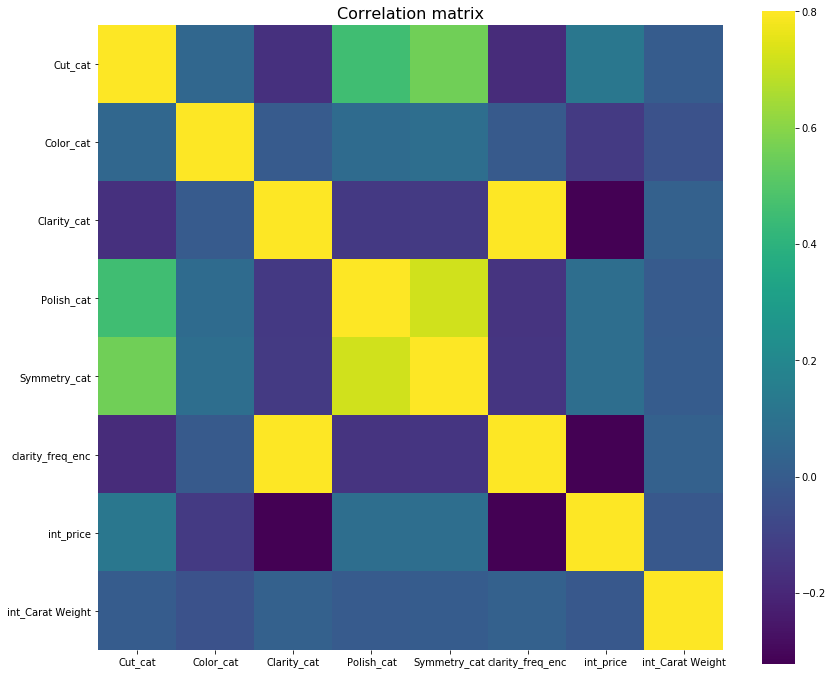

In [137]:
correlation = train.corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation matrix", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [138]:
print("Correlation of Numeric Features with Target")
correlation = train.corr()
corr_with_target1 = abs(correlation["int_price"]).sort_values(ascending = False)
corr_with_target1

Correlation of Numeric Features with Target


int_price           1.000000
Clarity_cat         0.320941
clarity_freq_enc    0.319041
Color_cat           0.128445
Cut_cat             0.121845
Symmetry_cat        0.081160
Polish_cat          0.078291
int_Carat Weight    0.018527
Name: int_price, dtype: float64

Вывод: самая большая ЛИНЕЙНАЯ кореляция между чистотой и ценой. Параметры полировки и симметрии сильно взаимно корелированы.  

In [139]:
train, valid = train_test_split(train, test_size=0.3, random_state=42)

In [140]:
#стандартизация
scaler = StandardScaler()
train['Carat Weight2'] = scaler.fit_transform(train[['Carat Weight']])
valid['Carat Weight2'] = scaler.transform(valid[['Carat Weight']])

test['Carat Weight2'] = scaler.transform(test[['Carat Weight']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [149]:
#набор полей для модели
fts = ["Carat Weight2", "Cut_cat", "Color_cat", "Clarity_cat", "Polish_cat"]

target =  "Price"

масштабирование веса

линейная регрессия

In [150]:
lr1 = linear_regression(fts, target)

метрика R2 для тренировочного набора train: 0.11467659235438232
метрика R2 для валидационного набора valid: 0.14767343232355412
метрика MSE: 91624008.63713329


Дерево решений: n_estimators=1 (где n_estimators - количество деревьев)

In [151]:
from sklearn.ensemble import RandomForestRegressor as RF

In [152]:
for i in range(10,5,-1):
    print(f'max_depth={i}')
    dt = RF(max_depth=i, n_estimators=1, max_features=3, random_state=100)
    dt.fit(train.loc[:,fts], train[target])
    pred = dt.predict(train.loc[:,fts])
    print(r2(train[target],pred))
    pred_valid = dt.predict(valid.loc[:,fts])
    print(r2(valid[target],pred_valid))
    print()

max_depth=10
0.9669333573722911
0.9283590481028916

max_depth=9
0.9587487681979407
0.910308995254252

max_depth=8
0.9611935748033782
0.9308848779918069

max_depth=7
0.9450815565185571
0.909742274802749

max_depth=6
0.9431454004902009
0.9105218391913122



In [153]:
print('метрика MSE: ',MSE(valid[target],pred_valid))

метрика MSE:  9618787.081951212


RandomForest - случайный лес

In [154]:
from sklearn.ensemble import RandomForestRegressor as RF

In [155]:
for i in range(10,5,-1):
    print(f'max_depth={i}')
    rf = RF(max_depth=i, n_estimators=60, max_features=3, random_state=100)
    rf.fit(train.loc[:,fts], train[target])
    pred = rf.predict(train.loc[:,fts])
    print(r2(train[target],pred))
    pred_valid = rf.predict(valid.loc[:,fts])
    print(r2(valid[target],pred_valid))
    print()

max_depth=10
0.9866636289759485
0.957855238671157

max_depth=9
0.9846008017578127
0.9616307844896543

max_depth=8
0.9808072497845268
0.9589128251847377

max_depth=7
0.9756728432809554
0.9568328902558578

max_depth=6
0.9673097447069476
0.949711299492331



In [156]:
rf = RF(max_depth=10,n_estimators=60,max_features=3,random_state=100)

In [157]:
rf.fit(train.loc[:,fts],train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=None, oob_score=False, random_state=100,
           verbose=0, warm_start=False)

In [158]:
pred = rf.predict(train.loc[:,fts])

In [159]:
print('метрика R2 для тренировочного набора train:', r2(train[target], pred))

метрика R2 для тренировочного набора train: 0.9866636289759485


In [160]:
pred_valid = rf.predict(valid.loc[:,fts])

In [161]:
print('метрика R2 для валидационного набора valid: ', r2(valid[target],pred_valid))

метрика R2 для валидационного набора valid:  0.957855238671157


In [162]:
print('метрика MSE: ',MSE(valid[target],pred_valid))

метрика MSE:  4530507.580598735


In [163]:
#подсчет важности каждого признака
perm_importance1 = calculate_permutation_importance(
    estimator=rf, metric=r2, x_valid=valid.loc[:,fts], y_valid=valid[target]
)

In [164]:
perm_importance1

Carat Weight2    1.417354
Clarity_cat      0.182886
Color_cat        0.155759
Cut_cat          0.002500
Polish_cat       0.001826
dtype: float64

KNN

In [165]:
from sklearn.neighbors import KNeighborsRegressor as KNN

In [166]:
knn1 = knn(fts, target)

метрика R2 для тренировочного набора train: 0.993919623042052
метрика R2 для валидационного набора valid: 0.8359151380402247
метрика MSE: 17638911.398022298


Вывод: самая лучшая модель RandomForest (случайный лес). Она дает наилучшие предсказания, но является неинтерпритируемой! Из интерпритируемых моделей наилучшие предсказания дает дерево решений и KNN (метод ближайших соседей). Линейная регрессия (lr) дает наихудшие предсказания из всех моделей.

In [167]:
test2 = df[df['Price'].isnull()]
test_id = test2['ID']

In [168]:
test.isnull().sum()

Carat Weight           0
Cut_cat                0
Color_cat              0
Clarity_cat            0
Polish_cat             0
Symmetry_cat           0
Price               1500
clarity_freq_enc       0
Carat Weight2          0
dtype: int64

In [169]:
test_target = rf.predict(test.loc[:,fts])

In [170]:
y_pred = pd.DataFrame({
    "ID": test_id,
    "Price": test_target
})
y_pred.to_csv("./Data/rf_VZinchenko_result_pred.csv",index=False)

In [171]:
y_pred

,ID,Price
4502,4501,7225.495535
4503,4502,7751.491052
4504,4503,23939.205916
4505,4504,3430.453726
4506,4505,3591.863419
...,...,...
5997,5996,5922.755072
5998,5997,5539.176022
5999,5998,5896.496445
6000,5999,9670.190374
